In [21]:
import pandas as pd; pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import warnings; warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact
import ipywidgets as widgets
from datetime import datetime
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)
from dmyplant2 import msgFSM, FSMPlot_Start, bokeh_show, filterFSM

In [2]:
def sfun(x):
    return all([
            #("Forsa Hartmoor" in str(x['IB Site Name'])), 
            ("BMW Landshut 4.10" in str(x['IB Site Name'])), 
            #("M4" in str(x['Engine ID'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
pname = 'persist.json'
try:
    persist_dialog = dmyplant2.load_json(pname)
except FileNotFoundError:        
    persist_dialog = {
        'dl': 0,
        'modes': [
                {'name':'???','value':False },
                {'name':'OFF','value':False },
                {'name':'MANUAL','value':False},
                {'name':'AUTO','value':True }],
        'starts': [   
                {'name':'True','value':True },
                {'name':'False','value':False }]   
    }
    dmyplant2.save_json(pname,persist_dialog)

In [4]:
    fleet.T

,0,1,2,3
Count_OpHour,14978.0,14076.0,14896.0,18263.0
OperationalCondition,Available,Available,Available,Available
shutdown_counter,1376.0,1406.0,1175.0,1063.0
startup_counter,1375.0,1403.0,1173.0,1055.0
id,117510,117531,117547,117617
Engine Version,H01,H01,H01,H01
Engine Type,624,624,624,624
Engine Series,6,6,6,6
Country,DE,DE,DE,DE
Commissioning Date,2019-01-07,2019-01-09,2019-01-09,2019-01-09


In [15]:
# Dialog
persist_dialog = dmyplant2.load_json(pname)
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
#dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
dl=widgets.Dropdown(options = ddl,value=persist_dialog['dl'],description='Engine:',layout={'width':'auto'},disabled=False)
out = widgets.Output(layout={'height':'auto', 'width':'auto'})
rmodes = persist_dialog['modes']
service_selector_modes = [] 
modes = []
for mm in rmodes:
    service_selector_modes.append(widgets.Checkbox(
        value=mm['value'], 
        description=mm['name'],
        layout={'width':'auto'},
        disabled=False,indent=False))

rsucc = persist_dialog['starts']
successful_starts = []; 
for rs in rsucc:
    successful_starts.append(widgets.Checkbox(
            value=(str(rs['value']) == rs['name']),
            description=rs['name'],
            layout={'width':'auto'},
            disabled=False,indent=False))

app = AppLayout(  header=dl,
            #left_sidebar=Button(description='center', button_style='warning', layout=Layout(height='auto', width='auto')),
            left_sidebar=None,
            center=HBox([
                VBox(service_selector_modes),
                VBox(successful_starts),
                out
            ]),
            right_sidebar=None,
            footer = None,
            #footer = Button(description='footer', button_style='success', layout=Layout(height='auto', width='auto')),
            pane_widths=['10px',1,'10px'],
            pane_heights=['40px','250px','40px']
            )
display(app)

AppLayout(children=(Dropdown(description='Engine:', index=3, layout=Layout(grid_area='header', width='auto'), …

In [16]:
# Load Engine Data and execute FSM Run 1 - display Results 
persist_dialog = {
    'dl':dl.value, 
    'modes': [{'name':cb.description, 'value':cb.value} for cb in service_selector_modes],
    'starts': [{'name':cb.description, 'value': str(cb.value) == cb.description} for cb in successful_starts]}
dmyplant2.save_json(pname,persist_dialog)
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
#fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=arrow.now(), frompickle=True)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=datetime.now(), frompickle=True)
fsm.run1(enforce=False) # run Finite State Machine
fsm.store()

FSM: 100%|█████████████████████| 138834/138834 [00:30<00:00, 4621.46 messages/s]


In [17]:
out.clear_output()
with out:
    fsm.summary_out()
rdf = fsm.starts
#rdf[fsm.filters['filter_content']].round(2)
modes = [rmodes[i]['name'] for i,v in enumerate(service_selector_modes) if v.value]
success = [rsucc[i]['value'] for i,v in enumerate(successful_starts) if v.value]
rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))]
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
print(modes, success)
#rda[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [18]:
# Execute FSM Run 2
#rda = fsm.run2(rda)
#fsm.store()

In [22]:
rdb = rda
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb[filterFSM.run2filter_content].round(2)

,no,success,mode,startpreparation,starter,speedup,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,rampdown,coolrun,runout,count_alarms,count_warnings
0,0,True,???,265.13,4.41,14.31,7.97,25.82,138.89,456.53,NaN,NaN,132813.68,127.53,0.00,49.41,0,4
1,1,True,AUTO,350.70,4.64,15.00,7.78,12.50,138.89,529.50,NaN,NaN,1572.52,0.31,0.00,44.76,2,3
2,2,True,AUTO,265.01,4.74,13.91,7.67,19.33,138.89,449.53,NaN,NaN,109680.23,96.69,0.00,49.47,0,7
3,3,False,AUTO,255.37,NaN,NaN,NaN,NaN,NaN,255.37,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,4,False,AUTO,255.41,NaN,NaN,NaN,NaN,NaN,255.41,NaN,NaN,NaN,NaN,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,1126,True,AUTO,261.39,4.94,14.63,6.57,15.63,138.89,442.04,NaN,NaN,1183.51,127.79,9.99,49.43,0,6
1127,1127,True,AUTO,261.48,5.14,14.34,6.46,18.49,138.89,444.81,NaN,NaN,3565.72,127.80,9.99,49.32,0,3
1128,1128,True,AUTO,200.99,4.73,14.42,6.04,19.41,138.89,384.47,NaN,NaN,187424.19,127.97,9.83,49.06,0,5
1129,1129,False,AUTO,262.05,4.23,19.09,6.64,16.06,138.89,446.97,NaN,NaN,242.28,86.29,10.01,46.84,0,0


,startpreparation,speedup,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,coolrun
count,1131.00,1031.00,1020.00,1008.00,990.00,0.0,0.0,1131.00,946.00
mean,247.77,16.39,18.49,16.56,-1019.37,NaN,NaN,-593.40,129.29
std,73.56,2.56,74.10,9.15,21999.66,NaN,NaN,20569.77,1481.56
min,0.10,3.02,5.77,0.40,-656811.13,NaN,NaN,-655998.19,0.00
25%,261.49,14.91,6.75,10.13,138.89,NaN,NaN,435.83,0.00
50%,262.61,15.83,7.48,16.63,138.89,NaN,NaN,444.49,9.98
75%,263.43,17.46,8.18,19.40,138.89,NaN,NaN,450.45,10.01
max,1133.98,35.56,1920.20,81.96,138.89,NaN,NaN,2097.94,29666.25


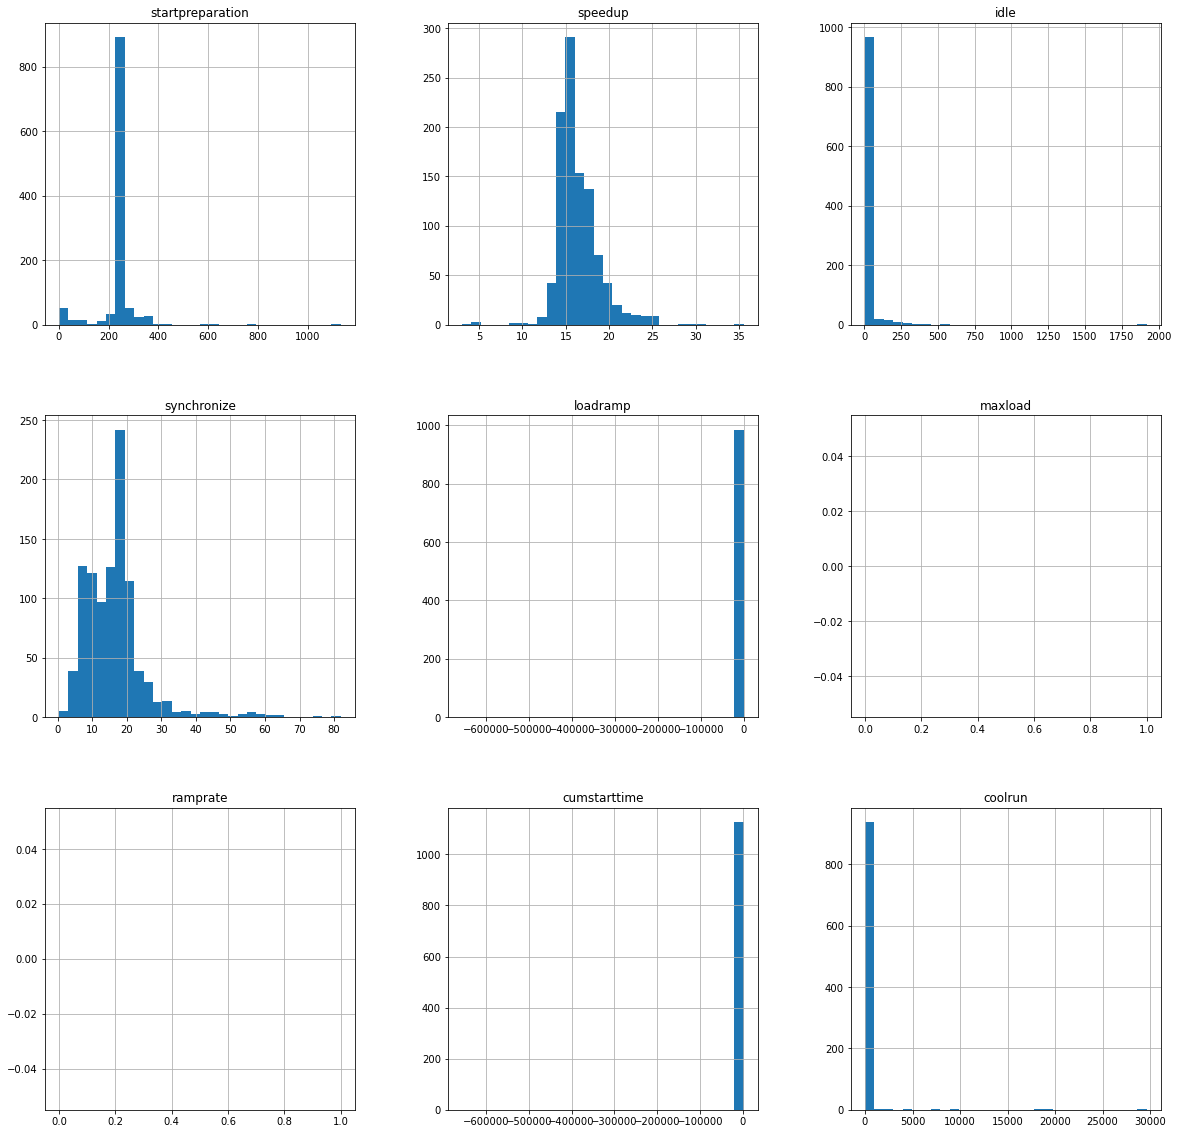

In [24]:
display(_=rdb[['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','coolrun']].hist(bins=30,figsize=(20,20)))
display(rdb[['startpreparation','speedup','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','coolrun']].describe().round(2))

In [30]:
vset = ['Power_PowerAct','Various_Values_SpeedAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]
dfigsize = (18,12)

In [28]:
@interact(x = (0, rdb.shape[0]-1))
def f(x=0):
    global v
    v = x
    startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    print(ftitle)
    fsm.disp_result(startversuch)

interactive(children=(IntSlider(value=0, description='x', max=1130), Output()), _dom_classes=('widget-interact…

In [29]:
fig = FSMPlot_Start(fsm,rdb.iloc[v], vset, dset, figsize=dfigsize)
bokeh_show(fig)
fig.renderers = []

TypeError: FSMPlot_Start() missing 1 required positional argument: 'dset'

In [ ]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success']) & (rda['maxload'] > 4000.0)]
rde['datetime'] = pd.to_datetime(rde['starttime'])
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-50,650)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'orange'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['index'],'color':'black'},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dmyplant2.dbokeh_chart(rde, dset, style='circle', figsize=dfigsize ,title=ftitle);
bokeh_show(fig)
fig.renderers = []

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 100
_txt = ''
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        _txt += f"<h3>Startversuch: {i}, Success: {c['success']}</h3>"
        #display(HTML(f"\n<hr><h3>Startversuch: {i}, Success: {c['success']}</h3>"))
        print()
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt += f"{ct2} {c['mode']:15} {a['state']:20} " + fsm.msgtxt(a['msg']) + "<br>"
            #_txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            #if ct2 >= mini and ct2 <= maxi:
                #fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                #plt.show()
            ct2 += 1
_txt = f"<h2>{fsm._e}, <br>{ct:3} not successful starts</h2>" + _txt
display(HTML(_txt))


In [ ]:
# BUG: code funktioniert nicht, wenn das Resultat vom Pickle File geladen wird.
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun']
for phase in phases:
    al = fsm.alarms_pareto(phase)
    if not al.empty:
        display(HTML(f"<hr><h3>{phase}:</h3>"))
        al.sort_values(by = "anz",ascending=True)
        display(HTML(al.to_html(escape=False, index=False)))

In [ ]:
# BUG: code funktioniert nicht, wenn das Resultat vom Pickle File geladen wird.
for phase in phases:
    wr = fsm.warnings_pareto(phase)
    if not wr.empty:
        display(HTML(f"<hr><h3>{phase}:</h3>"))
        wr.sort_values(by = "anz",ascending=True)
        display(HTML(wr.to_html(escape=False, index=False)))